# Предсказание стоимости автомобиля на вторичном рынке

## Установка и импорт библиотек

In [1]:
!pip install optuna

  Using cached optuna-3.1.1-py3-none-any.whl (365 kB)
  Using cached cmaes-0.9.1-py3-none-any.whl (21 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached alembic-1.11.1-py3-none-any.whl (224 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)


In [2]:
!pip install catboost

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from catboost import cv, Pool
import catboost as cb
from sklearn.metrics import *
import shap
# from pycaret.regression import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import phik

## Загрузка данных

In [4]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
ss = pd.read_csv('sample_submission.csv')
sub = df_test.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [6]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


Имеем датасет из 15 колонок и 440236 объектов. Целевой признак - sellingprice(уена автомобиля), которую надо предсказать, решив задачу регрессии, используя остальные 14 признаков.

 ### Посмотрим на распределение цены на автомобили

In [7]:
df['sellingprice'].describe()

count    440236.000000
mean      13592.209588
std        9751.479098
min           1.000000
25%        6900.000000
50%       12100.000000
75%       18200.000000
max      230000.000000
Name: sellingprice, dtype: float64

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


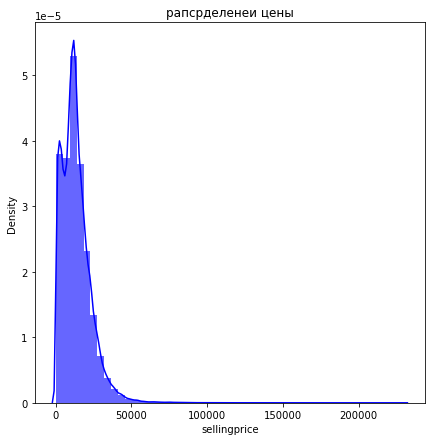

In [12]:
plt.figure(figsize=(7, 7))
ax = sns.distplot(df['sellingprice'], color='b', hist_kws={'alpha': 0.6});
ax.set(title='рапсрделенеи цены')
plt.show()

In [13]:
df.sellingprice.describe()

count    440236.000000
mean      13592.209588
std        9751.479098
min           1.000000
25%        6900.000000
50%       12100.000000
75%       18200.000000
max      230000.000000
Name: sellingprice, dtype: float64

Теперь посмотрим на распределение других численых признаков

In [14]:
df_num = df.select_dtypes(include = ['float64', 'int64']).drop('sellingprice', axis = 1).columns
df_cat = df.select_dtypes(include = ['object']).columns

In [16]:
df

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440231,2013,Kia,Optima,EX Hybrid,Sedan,automatic,knagm4ad4d5057805,ca,4.5,20434.0,white,beige,"kia motors america, inc",16000,Tue Jan 20 2015 04:30:00 GMT-0800 (PST)
440232,2014,MINI,Cooper Countryman,S ALL4,Wagon,automatic,wmwzc5c55ewp36517,wi,2.9,14675.0,white,black,bmw mini financial services,24250,Wed Feb 11 2015 02:00:00 GMT-0800 (PST)
440233,2008,BMW,6 Series,650i,Coupe,automatic,wbaea53588cv90110,ca,3.7,102552.0,gray,black,studio city auto group,16750,Tue Mar 03 2015 04:30:00 GMT-0800 (PST)
440234,2014,Ram,2500,SLT,Crew Cab,automatic,3c6ur5dl2eg243568,tx,3.0,29367.0,white,gray,express car & truck rental,33000,Wed Jan 14 2015 02:05:00 GMT-0800 (PST)


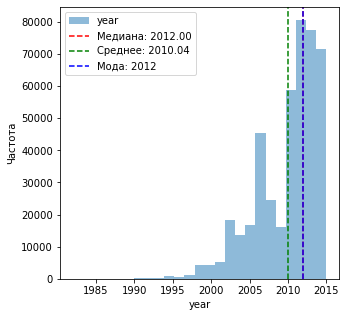

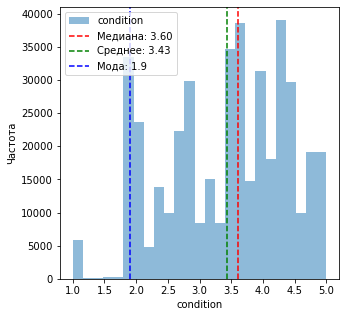

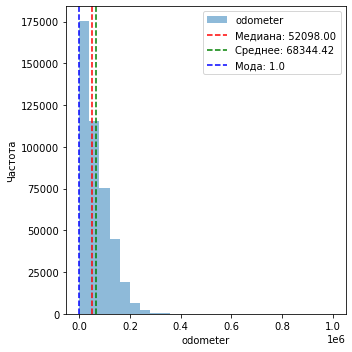

In [19]:

# Построение гистограмм для каждого признака

def plot_histogram_with_stats(dataframe, column):
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Гистограмма
    dataframe[column].plot.hist(ax=ax, bins=25, alpha=0.5)
    ax.set_xlabel(column)
    ax.set_ylabel('Частота')

    # Медиана
    median = dataframe[column].median()
    ax.axvline(median, color='r', linestyle='--', label=f'Медиана: {median:.2f}')

    # Среднее
    mean = dataframe[column].mean()
    ax.axvline(mean, color='g', linestyle='--', label=f'Среднее: {mean:.2f}')

    # Мода
    mode = stats.mode(dataframe[column])[0][0]
    ax.axvline(mode, color='b', linestyle='--', label=f'Мода: {mode}')

    ax.legend()

    
for column in df_num:
    plot_histogram_with_stats(df[df_num], column)
    
plt.tight_layout()
plt.show()


Корреляционное поле для всех признаков

interval columns not set, guessing: ['year', 'condition', 'odometer', 'sellingprice']


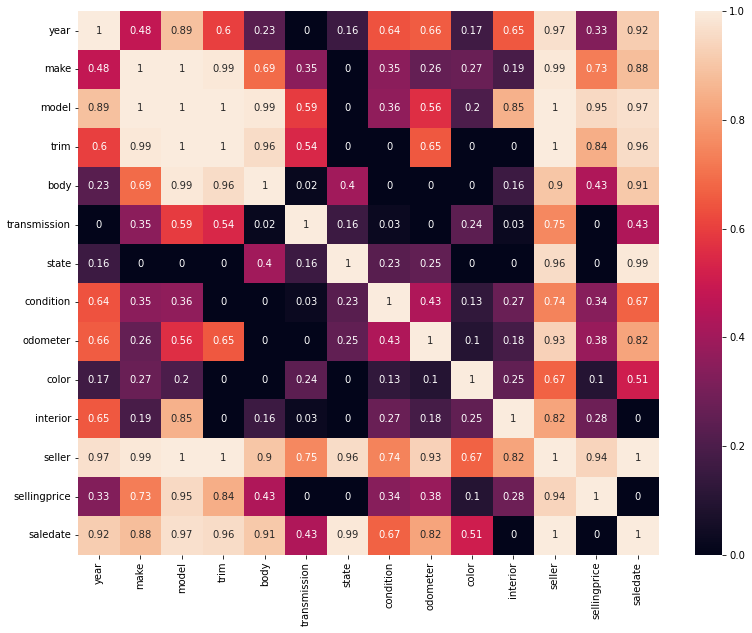

In [22]:
plt.figure(figsize=(13,10));
phik_overview = df.drop('vin', axis = 1).sample(n = 1000).phik_matrix()
sns.heatmap(phik_overview.round(2), annot = True);
plt.show();

Есть признаки, которые очень сильно коррелируют друг с другом.

## Предобрабокта данных

Вся обработка на тренировочных данных будет применена к тестовым

Есть несколько возможных вариантов борьбы с пропусками: оставить их, можем просто удалить все пропуски или заменить их на средее, медиану и т.д. в зависимости от самих пропусков и признаков.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


Посмотрим на пропуски

In [24]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total nuns', 'Percent'])
missing_data

,Total nuns,Percent
transmission,51461,0.116894
body,10393,0.023608
condition,9405,0.021364
trim,8337,0.018938
model,8123,0.018451
make,8043,0.018270
color,586,0.001331
interior,586,0.001331
odometer,69,0.000157
year,0,0.000000


По выше построенным графикам распределений и информации о пропусках я ссделаю следущее: численные признаки заменю медианой, а для признаком типа object создам новую категорию unknown

In [25]:
f_num = df.select_dtypes(include = ['float64', 'int64']).drop('sellingprice', axis = 1).columns
f_cat = df.select_dtypes(include = ['object']).columns

for i in f_cat:
    df[i].fillna('unknown', inplace = True)
    df_test[i].fillna('unknown', inplace = True)

for i in f_num:
    median = df[i].median()
    df[i].fillna(median, inplace = True)
    median = df_test[i].median()
    df_test[i].fillna(median, inplace = True)

In [26]:
df.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


Проверим пропуски

In [27]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total nuns', 'Percent'])
missing_data

,Total nuns,Percent
year,0,0.0
make,0,0.0
model,0,0.0
trim,0,0.0
body,0,0.0
transmission,0,0.0
vin,0,0.0
state,0,0.0
condition,0,0.0
odometer,0,0.0


Удалим признак vin, так как он не поможет в обучении, В признаке saledate оставим только месяц, также создадим новый признак - возраст машины. Приведем всё к нижнему ргеистру.

Построим поле корреляции

In [28]:
df.drop('vin', axis = 1, inplace = True)
df_test.drop('vin', axis = 1, inplace = True)


In [30]:
f_num = df.select_dtypes(include = ['float64', 'int64']).drop('sellingprice', axis = 1).columns
f_cat = df.select_dtypes(include = ['object']).columns

In [31]:
for i in f_cat:
    df[i] = df[i].str.lower()
    df_test[i] = df_test[i].str.lower()

In [32]:
def age(dfff):
    m = int(dfff['saledate'].split(" ")[3])
    return m - dfff['year']

df['age'] = df.apply(age, axis = 1)
df_test['age'] = df_test.apply(age, axis = 1)

In [33]:
def month(r):
    m = r.split(" ")[1]
    return m

df['saledate'] = df['saledate'].apply( month)
df_test['saledate'] = df_test['saledate'].apply( month)

In [34]:
df.head(10)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate,age
0,2011,ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,jun,4
1,2014,ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,feb,1
2,2012,nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,jun,3
3,2003,hummer,h2,base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,jun,12
4,2007,ford,fusion,sel,sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,feb,8
5,2013,lincoln,mkz,base,sedan,automatic,mi,2.5,14894.0,black,black,"ford motor credit company,llc",22600,may,2
6,2010,pontiac,g6,4c,unknown,automatic,nc,3.4,114587.0,silver,black,north state acceptance,5900,jan,5
7,2013,ford,escape,se,suv,automatic,fl,4.8,26273.0,blue,gray,fields bmw,15200,feb,2
8,2000,hyundai,elantra,gls,sedan,automatic,oh,1.9,182624.0,black,tan,dt inventory,700,jan,15
9,2005,ford,freestyle,limited,wagon,automatic,oh,1.0,149364.0,black,tan,wells fargo dealer services,325,jun,10


# replcaing implicit duplicates

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          440236 non-null  object 
 2   model         440236 non-null  object 
 3   trim          440236 non-null  object 
 4   body          440236 non-null  object 
 5   transmission  440236 non-null  object 
 6   state         440236 non-null  object 
 7   condition     440236 non-null  float64
 8   odometer      440236 non-null  float64
 9   color         440236 non-null  object 
 10  interior      440236 non-null  object 
 11  seller        440236 non-null  object 
 12  sellingprice  440236 non-null  int64  
 13  saledate      440236 non-null  object 
 14  age           440236 non-null  int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 50.4+ MB


In [36]:
f_num = df.select_dtypes(include = ['float64', 'int64']).drop('sellingprice', axis = 1).columns
f_cat = df.select_dtypes(include = ['object']).columns
X = list(df.drop('sellingprice', axis = 1).columns)
y = ['sellingprice']

In [37]:
for column in f_cat:
    print(column)
    print(len(df[column].unique()))
#     print(df[column].unique())
    print('--------------------')

make
63
--------------------
model
840
--------------------
trim
1851
--------------------
body
46
--------------------
transmission
3
--------------------
state
38
--------------------
color
21
--------------------
interior
18
--------------------
seller
13025
--------------------
saledate
8
--------------------


In [38]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd

# Функуия для заменвы неявных дупликатов
def replace_duplicates(df, column_name):
    
    
    duplicate_mapping = {}

    
    unique_values = df[column_name].unique()
    for value in unique_values:
    
        best_match, _ = process.extractOne(value, unique_values, scorer=fuzz.ratio)

    
        duplicate_mapping[value] = best_match

    
    df[column_name] = df[column_name].map(duplicate_mapping)
    print(column_name, ' done')
    return df





categorical_columns = ['make', 'model', 'trim', 'body', 'seller'] 
for column in categorical_columns:
    df = replace_duplicates(df, column)
    df_test = replace_duplicates(df_test, column)



make  done
make  done
model  done
model  done


trim  done


trim  done
body  done
body  done
seller  done
seller  done


In [39]:
for column in f_cat:
    print(column)
    print(len(df[column].unique()))
#     print(df[column].unique())
    print('--------------------')

make
63
--------------------
model
840
--------------------
trim
1831
--------------------
body
45
--------------------
transmission
3
--------------------
state
38
--------------------
color
21
--------------------
interior
18
--------------------
seller
13006
--------------------
saledate
8
--------------------


In [40]:
df.head(5)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,saledate,age
0,2011,ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,jun,4
1,2014,ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,feb,1
2,2012,nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,jun,3
3,2003,hummer,h2,base,suv,automatic,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,jun,12
4,2007,ford,fusion,sel,sedan,automatic,md,2.0,127709.0,black,black,purple heart,1300,feb,8


## target encoding

Применим TargetEncoder к категориальным признакам

In [41]:
f_cat

Index(['make', 'model', 'trim', 'body', 'transmission', 'state', 'color',
       'interior', 'seller', 'saledate'],
      dtype='object')

In [42]:

target = df['sellingprice'].copy()
categorical_columns = f_cat  
encoder = ce.TargetEncoder(cols=categorical_columns)
df = encoder.fit_transform(df[X], df[y])
df['sellingprice'] = target

df_test = encoder.transform(df_test)

In [43]:
df.head(5)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate,age,sellingprice
0,2011,14472.905977,18821.180051,14298.340634,16101.931946,13525.219647,7448.989614,4.2,111041.0,15499.045687,15680.215374,7904.449305,14952.578470,4,12500
1,2014,14472.905977,12363.716810,11212.039481,11715.115204,13525.219647,14462.472499,3.5,31034.0,15499.045687,15680.215374,18164.501134,13625.503411,1,14500
2,2012,11728.012201,8743.003000,8537.996099,11715.115204,13525.219647,13629.736268,2.2,35619.0,15499.045687,15680.215374,16450.107370,14952.578470,3,9100
3,2003,15247.886097,18510.585577,13819.751664,16101.931946,13525.219647,13159.645441,2.8,131301.0,8302.543989,13341.925637,16458.674141,14952.578470,12,13300
4,2007,14472.905977,12363.716810,14298.340634,11715.115204,13525.219647,7448.989614,2.0,127709.0,15499.045687,15680.215374,904.778831,13625.503411,8,1300


## standardscaler encoding

Применим StandardScaler ко всем признкаам

In [44]:
scaler = StandardScaler()
scaler.fit(df[X])

df[X] = pd.DataFrame(scaler.transform(df[X]), columns = df[X].columns)
df_test[X] = pd.DataFrame(scaler.transform(df_test[X]), columns = df_test[X].columns)

In [45]:
df.head(5)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate,age,sellingprice
0,0.241305,0.208063,0.829650,0.126728,0.790372,-0.113199,-2.798382,0.820315,0.797543,0.908378,0.866512,-0.973753,1.377494,-0.218090,12500
1,0.995464,0.208063,-0.190769,-0.408744,-0.589653,-0.113199,0.396331,0.075721,-0.696844,0.908378,0.866512,0.727994,0.033713,-0.976742,14500
2,0.492692,-0.434502,-0.762920,-0.872689,-0.589653,-0.113199,0.017011,-1.307095,-0.611205,0.908378,0.866512,0.443642,1.377494,-0.470974,9100
3,-1.769785,0.389482,0.780569,0.043693,0.790372,-0.113199,-0.197120,-0.668872,1.175963,-2.520008,-0.103852,0.445063,1.377494,1.804982,13300
4,-0.764240,0.208063,-0.190769,0.126728,-0.589653,-0.113199,-2.798382,-1.519836,1.108871,0.908378,0.866512,-2.134729,0.033713,0.793446,1300


In [46]:
df_wp = df.copy()
df_test_wp = df_test.copy()

# choosing the best params

Выобр лучших параметров с помощью оптуны

In [47]:
# import catboost as cb
# import optuna
# from sklearn.metrics import mean_absolute_percentage_error

# X = df_wp.drop('sellingprice', axis = 1)
# y = df_wp.sellingprice
# X_t, X_v, y_t, y_v = train_test_split(
#     X, y, test_size = 0.2, random_state = 199)

# def objective(trial):
#     params = {
#         'loss_function': 'RMSE',
#         'eval_metric': 'MAPE',
#         'depth': trial.suggest_int('depth', 3, 15, step = 1),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.4),
#         'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.4, 0.9, 0.1),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 3000, step=100),
#         'random_state': 199
#     }

#     model = cb.CatBoostRegressor(**params)
#     model.fit(X_t, y_t, verbose=False)

#     y_pred = model.predict(X_v)
    
#     mape = mean_absolute_percentage_error(y_v, y_pred)

#     return mape

# study = optuna.create_study(direction='minimize')

# study.optimize(objective, n_trials=15)

# best_params = study.best_params
# best_score = study.best_value

# print("Best mape-score: {}".format(best_score))
# print("Best Hyperparameters: {}".format(best_params))

Запускаю на локальном, поэтому слишком долго будет грпзить результат. Просто вставлю параметры, которые загрузилсись в кагле 

In [48]:
# optuna.visualization.plot_contour(study) 

Best mape-score: 0.14388227538414194
Best Hyperparameters: {'depth': 12, 'learning_rate': 0.17876487766088486, 'colsample_bylevel': 0.8, 'n_estimators': 1500}

In [49]:
best_params = {'depth': 12, 'learning_rate': 0.17876487766088486, 'colsample_bylevel': 0.8, 'n_estimators': 1500}

In [56]:
df

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate,age,sellingprice
0,0.241305,0.208063,0.829650,0.126728,0.790372,-0.113199,-2.798382,0.820315,0.797543,0.908378,0.866512,-0.973753,1.377494,-0.218090,12500
1,0.995464,0.208063,-0.190769,-0.408744,-0.589653,-0.113199,0.396331,0.075721,-0.696844,0.908378,0.866512,0.727994,0.033713,-0.976742,14500
2,0.492692,-0.434502,-0.762920,-0.872689,-0.589653,-0.113199,0.017011,-1.307095,-0.611205,0.908378,0.866512,0.443642,1.377494,-0.470974,9100
3,-1.769785,0.389482,0.780569,0.043693,0.790372,-0.113199,-0.197120,-0.668872,1.175963,-2.520008,-0.103852,0.445063,1.377494,1.804982,13300
4,-0.764240,0.208063,-0.190769,0.126728,-0.589653,-0.113199,-2.798382,-1.519836,1.108871,0.908378,0.866512,-2.134729,0.033713,0.793446,1300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440231,0.744078,-0.407045,-0.025076,0.540403,-0.589653,-0.113199,0.433187,1.139426,-0.894833,0.536632,-0.103852,0.384085,-0.316299,-0.723858,16000
440232,0.995464,-0.289584,0.874355,1.228722,-1.095817,-0.113199,0.127499,-0.562502,-1.002401,0.536632,0.866512,0.064986,0.033713,-0.976742,24250
440233,-0.512854,1.864275,3.125614,3.950089,0.692766,-0.113199,0.433187,0.288462,0.638984,0.161526,0.866512,0.037772,-0.162364,0.540562,16750
440234,0.995464,2.727240,2.998224,0.296799,2.510445,-0.113199,-0.197120,-0.456131,-0.727981,0.536632,-1.074537,3.234431,-0.316299,-0.976742,33000


In [57]:
model = cb.CatBoostRegressor(**best_params)
model.fit(df[X], df[y])
predictions = model.predict(df_test)
submission = pd.DataFrame({ 'vin': sub['vin'], 'sellingprice': predictions})

0:	learn: 8431.8218516	total: 364ms	remaining: 9m 5s
1:	learn: 7359.8152916	total: 581ms	remaining: 7m 15s
2:	learn: 6498.6882142	total: 758ms	remaining: 6m 18s
3:	learn: 5808.0171952	total: 900ms	remaining: 5m 36s
4:	learn: 5258.4766922	total: 1.03s	remaining: 5m 8s
5:	learn: 4817.8654113	total: 1.15s	remaining: 4m 47s
6:	learn: 4478.4656909	total: 1.27s	remaining: 4m 30s
7:	learn: 4204.6352431	total: 1.4s	remaining: 4m 20s
8:	learn: 3988.1947482	total: 1.59s	remaining: 4m 24s
9:	learn: 3825.5451315	total: 1.78s	remaining: 4m 25s
10:	learn: 3700.8872739	total: 1.95s	remaining: 4m 24s
11:	learn: 3598.8096686	total: 2.07s	remaining: 4m 17s
12:	learn: 3509.1178668	total: 2.22s	remaining: 4m 13s
13:	learn: 3436.4346511	total: 2.4s	remaining: 4m 15s
14:	learn: 3377.6851530	total: 2.59s	remaining: 4m 16s
15:	learn: 3329.5722672	total: 2.76s	remaining: 4m 16s
16:	learn: 3274.8648336	total: 2.94s	remaining: 4m 16s
17:	learn: 3238.7116165	total: 3.06s	remaining: 4m 12s
18:	learn: 3194.5648047	

150:	learn: 1982.4854700	total: 22.6s	remaining: 3m 21s
151:	learn: 1979.5609026	total: 22.7s	remaining: 3m 21s
152:	learn: 1978.2166548	total: 22.8s	remaining: 3m 20s
153:	learn: 1974.5339509	total: 22.9s	remaining: 3m 20s
154:	learn: 1971.8754000	total: 23.1s	remaining: 3m 20s
155:	learn: 1968.0899084	total: 23.2s	remaining: 3m 19s
156:	learn: 1965.4115841	total: 23.3s	remaining: 3m 19s
157:	learn: 1960.3544512	total: 23.5s	remaining: 3m 19s
158:	learn: 1958.0298903	total: 23.6s	remaining: 3m 19s
159:	learn: 1955.3644975	total: 23.7s	remaining: 3m 18s
160:	learn: 1953.2418895	total: 23.9s	remaining: 3m 18s
161:	learn: 1947.9348946	total: 24s	remaining: 3m 18s
162:	learn: 1945.2164743	total: 24.1s	remaining: 3m 17s
163:	learn: 1941.9504958	total: 24.2s	remaining: 3m 17s
164:	learn: 1940.0767773	total: 24.4s	remaining: 3m 17s
165:	learn: 1935.5608586	total: 24.5s	remaining: 3m 16s
166:	learn: 1933.5510562	total: 24.6s	remaining: 3m 16s
167:	learn: 1931.5299423	total: 24.7s	remaining: 3

297:	learn: 1689.7320260	total: 50.1s	remaining: 3m 22s
298:	learn: 1688.1197253	total: 50.3s	remaining: 3m 21s
299:	learn: 1686.6251272	total: 50.5s	remaining: 3m 21s
300:	learn: 1685.1805575	total: 50.6s	remaining: 3m 21s
301:	learn: 1684.1027739	total: 50.8s	remaining: 3m 21s
302:	learn: 1682.2082751	total: 51s	remaining: 3m 21s
303:	learn: 1681.2520786	total: 51.2s	remaining: 3m 21s
304:	learn: 1680.0859757	total: 51.4s	remaining: 3m 21s
305:	learn: 1678.4669769	total: 51.6s	remaining: 3m 21s
306:	learn: 1676.9588049	total: 51.8s	remaining: 3m 21s
307:	learn: 1675.4710716	total: 52s	remaining: 3m 21s
308:	learn: 1674.5158610	total: 52.2s	remaining: 3m 21s
309:	learn: 1672.7331606	total: 52.4s	remaining: 3m 21s
310:	learn: 1671.1797453	total: 52.6s	remaining: 3m 21s
311:	learn: 1669.3062213	total: 52.8s	remaining: 3m 21s
312:	learn: 1667.7139006	total: 53s	remaining: 3m 20s
313:	learn: 1666.5364702	total: 53.2s	remaining: 3m 20s
314:	learn: 1665.2420612	total: 53.3s	remaining: 3m 20

443:	learn: 1534.9512804	total: 1m 21s	remaining: 3m 13s
444:	learn: 1533.9952989	total: 1m 21s	remaining: 3m 13s
445:	learn: 1533.2551155	total: 1m 21s	remaining: 3m 12s
446:	learn: 1531.5391272	total: 1m 21s	remaining: 3m 12s
447:	learn: 1530.7993931	total: 1m 22s	remaining: 3m 12s
448:	learn: 1529.9712244	total: 1m 22s	remaining: 3m 12s
449:	learn: 1528.7089151	total: 1m 22s	remaining: 3m 12s
450:	learn: 1527.6097904	total: 1m 22s	remaining: 3m 12s
451:	learn: 1526.9081309	total: 1m 22s	remaining: 3m 12s
452:	learn: 1526.3353245	total: 1m 23s	remaining: 3m 12s
453:	learn: 1525.2526691	total: 1m 23s	remaining: 3m 11s
454:	learn: 1524.2087670	total: 1m 23s	remaining: 3m 11s
455:	learn: 1523.3920448	total: 1m 23s	remaining: 3m 11s
456:	learn: 1522.8455952	total: 1m 24s	remaining: 3m 11s
457:	learn: 1521.8763666	total: 1m 24s	remaining: 3m 11s
458:	learn: 1521.1978016	total: 1m 24s	remaining: 3m 11s
459:	learn: 1520.5636044	total: 1m 24s	remaining: 3m 11s
460:	learn: 1519.7068795	total:

589:	learn: 1424.8456723	total: 1m 58s	remaining: 3m 2s
590:	learn: 1424.2968652	total: 1m 58s	remaining: 3m 1s
591:	learn: 1424.0316986	total: 1m 58s	remaining: 3m 1s
592:	learn: 1423.1751829	total: 1m 58s	remaining: 3m 1s
593:	learn: 1422.6462281	total: 1m 58s	remaining: 3m 1s
594:	learn: 1421.8950361	total: 1m 59s	remaining: 3m 1s
595:	learn: 1421.5390125	total: 1m 59s	remaining: 3m 1s
596:	learn: 1421.0159058	total: 1m 59s	remaining: 3m
597:	learn: 1420.1989051	total: 1m 59s	remaining: 3m
598:	learn: 1419.4908146	total: 2m	remaining: 3m
599:	learn: 1418.5718760	total: 2m	remaining: 3m
600:	learn: 1417.9106688	total: 2m	remaining: 3m
601:	learn: 1417.3146950	total: 2m	remaining: 3m
602:	learn: 1416.7449141	total: 2m 1s	remaining: 2m 59s
603:	learn: 1416.1008953	total: 2m 1s	remaining: 2m 59s
604:	learn: 1415.4931552	total: 2m 1s	remaining: 2m 59s
605:	learn: 1414.8130523	total: 2m 1s	remaining: 2m 59s
606:	learn: 1414.3319826	total: 2m 2s	remaining: 2m 59s
607:	learn: 1412.8790660	t

735:	learn: 1340.9268059	total: 2m 29s	remaining: 2m 35s
736:	learn: 1340.7192517	total: 2m 30s	remaining: 2m 35s
737:	learn: 1340.1732375	total: 2m 30s	remaining: 2m 35s
738:	learn: 1339.5703344	total: 2m 30s	remaining: 2m 34s
739:	learn: 1339.2920958	total: 2m 30s	remaining: 2m 34s
740:	learn: 1338.3782008	total: 2m 30s	remaining: 2m 34s
741:	learn: 1337.8924651	total: 2m 30s	remaining: 2m 34s
742:	learn: 1337.3849876	total: 2m 31s	remaining: 2m 34s
743:	learn: 1336.6847797	total: 2m 31s	remaining: 2m 33s
744:	learn: 1336.2372480	total: 2m 31s	remaining: 2m 33s
745:	learn: 1335.6182821	total: 2m 31s	remaining: 2m 33s
746:	learn: 1335.0854265	total: 2m 31s	remaining: 2m 33s
747:	learn: 1334.6524648	total: 2m 32s	remaining: 2m 33s
748:	learn: 1334.1043195	total: 2m 32s	remaining: 2m 32s
749:	learn: 1333.4703888	total: 2m 32s	remaining: 2m 32s
750:	learn: 1332.9987676	total: 2m 32s	remaining: 2m 32s
751:	learn: 1332.4722983	total: 2m 32s	remaining: 2m 32s
752:	learn: 1331.8379449	total:

881:	learn: 1274.5938356	total: 2m 57s	remaining: 2m 4s
882:	learn: 1274.2057855	total: 2m 57s	remaining: 2m 3s
883:	learn: 1273.7414474	total: 2m 57s	remaining: 2m 3s
884:	learn: 1273.2168120	total: 2m 57s	remaining: 2m 3s
885:	learn: 1272.8086554	total: 2m 57s	remaining: 2m 3s
886:	learn: 1272.5922162	total: 2m 57s	remaining: 2m 2s
887:	learn: 1272.1804023	total: 2m 58s	remaining: 2m 2s
888:	learn: 1271.6472153	total: 2m 58s	remaining: 2m 2s
889:	learn: 1270.2687703	total: 2m 58s	remaining: 2m 2s
890:	learn: 1269.7988829	total: 2m 58s	remaining: 2m 2s
891:	learn: 1269.2160044	total: 2m 58s	remaining: 2m 1s
892:	learn: 1268.8329183	total: 2m 58s	remaining: 2m 1s
893:	learn: 1268.6645608	total: 2m 59s	remaining: 2m 1s
894:	learn: 1268.4842816	total: 2m 59s	remaining: 2m 1s
895:	learn: 1268.2199199	total: 2m 59s	remaining: 2m 1s
896:	learn: 1267.7065872	total: 2m 59s	remaining: 2m
897:	learn: 1267.1322702	total: 2m 59s	remaining: 2m
898:	learn: 1266.7178666	total: 3m	remaining: 2m
899:	

1027:	learn: 1215.9920609	total: 3m 26s	remaining: 1m 34s
1028:	learn: 1215.5329744	total: 3m 26s	remaining: 1m 34s
1029:	learn: 1215.1677958	total: 3m 27s	remaining: 1m 34s
1030:	learn: 1214.9461109	total: 3m 27s	remaining: 1m 34s
1031:	learn: 1214.6496036	total: 3m 27s	remaining: 1m 34s
1032:	learn: 1214.3175499	total: 3m 27s	remaining: 1m 33s
1033:	learn: 1214.0206279	total: 3m 27s	remaining: 1m 33s
1034:	learn: 1213.7756544	total: 3m 28s	remaining: 1m 33s
1035:	learn: 1213.4157623	total: 3m 28s	remaining: 1m 33s
1036:	learn: 1212.9954588	total: 3m 28s	remaining: 1m 33s
1037:	learn: 1212.3428297	total: 3m 28s	remaining: 1m 32s
1038:	learn: 1211.7429447	total: 3m 29s	remaining: 1m 32s
1039:	learn: 1211.4460570	total: 3m 29s	remaining: 1m 32s
1040:	learn: 1211.0130993	total: 3m 29s	remaining: 1m 32s
1041:	learn: 1210.7192570	total: 3m 29s	remaining: 1m 32s
1042:	learn: 1210.4341484	total: 3m 29s	remaining: 1m 31s
1043:	learn: 1210.1633054	total: 3m 30s	remaining: 1m 31s
1044:	learn: 1

1170:	learn: 1163.7008936	total: 3m 57s	remaining: 1m 6s
1171:	learn: 1163.4870893	total: 3m 58s	remaining: 1m 6s
1172:	learn: 1163.2928389	total: 3m 58s	remaining: 1m 6s
1173:	learn: 1163.0597403	total: 3m 58s	remaining: 1m 6s
1174:	learn: 1162.6544965	total: 3m 58s	remaining: 1m 6s
1175:	learn: 1162.4703921	total: 3m 59s	remaining: 1m 5s
1176:	learn: 1162.1023274	total: 3m 59s	remaining: 1m 5s
1177:	learn: 1161.8249257	total: 3m 59s	remaining: 1m 5s
1178:	learn: 1161.5504057	total: 3m 59s	remaining: 1m 5s
1179:	learn: 1161.4086215	total: 3m 59s	remaining: 1m 5s
1180:	learn: 1161.1788108	total: 4m	remaining: 1m 4s
1181:	learn: 1160.4189879	total: 4m	remaining: 1m 4s
1182:	learn: 1160.0474300	total: 4m	remaining: 1m 4s
1183:	learn: 1159.7440601	total: 4m	remaining: 1m 4s
1184:	learn: 1159.5578814	total: 4m 1s	remaining: 1m 4s
1185:	learn: 1159.1356384	total: 4m 1s	remaining: 1m 3s
1186:	learn: 1158.9135216	total: 4m 1s	remaining: 1m 3s
1187:	learn: 1158.4877151	total: 4m 1s	remaining: 

1316:	learn: 1120.6309071	total: 4m 27s	remaining: 37.1s
1317:	learn: 1120.3812942	total: 4m 27s	remaining: 36.9s
1318:	learn: 1120.0577256	total: 4m 27s	remaining: 36.7s
1319:	learn: 1119.6289690	total: 4m 27s	remaining: 36.5s
1320:	learn: 1119.4668891	total: 4m 28s	remaining: 36.3s
1321:	learn: 1119.2060226	total: 4m 28s	remaining: 36.1s
1322:	learn: 1118.9688718	total: 4m 28s	remaining: 35.9s
1323:	learn: 1118.6782767	total: 4m 28s	remaining: 35.7s
1324:	learn: 1118.2716249	total: 4m 28s	remaining: 35.5s
1325:	learn: 1117.8517796	total: 4m 29s	remaining: 35.3s
1326:	learn: 1117.8159597	total: 4m 29s	remaining: 35.1s
1327:	learn: 1117.4453549	total: 4m 29s	remaining: 34.9s
1328:	learn: 1117.2117436	total: 4m 29s	remaining: 34.7s
1329:	learn: 1116.8029462	total: 4m 29s	remaining: 34.5s
1330:	learn: 1116.4068555	total: 4m 29s	remaining: 34.3s
1331:	learn: 1116.0747048	total: 4m 30s	remaining: 34.1s
1332:	learn: 1115.6895723	total: 4m 30s	remaining: 33.9s
1333:	learn: 1115.3259131	total

1462:	learn: 1080.4062925	total: 4m 55s	remaining: 7.47s
1463:	learn: 1080.1385576	total: 4m 55s	remaining: 7.26s
1464:	learn: 1079.9905517	total: 4m 55s	remaining: 7.06s
1465:	learn: 1079.8153712	total: 4m 55s	remaining: 6.86s
1466:	learn: 1079.7004419	total: 4m 55s	remaining: 6.66s
1467:	learn: 1079.5685550	total: 4m 56s	remaining: 6.46s
1468:	learn: 1079.2594952	total: 4m 56s	remaining: 6.25s
1469:	learn: 1079.0467476	total: 4m 56s	remaining: 6.05s
1470:	learn: 1078.8950366	total: 4m 56s	remaining: 5.85s
1471:	learn: 1078.5048795	total: 4m 56s	remaining: 5.65s
1472:	learn: 1078.1983513	total: 4m 57s	remaining: 5.45s
1473:	learn: 1077.6145552	total: 4m 57s	remaining: 5.24s
1474:	learn: 1077.3955652	total: 4m 57s	remaining: 5.04s
1475:	learn: 1076.9813516	total: 4m 57s	remaining: 4.84s
1476:	learn: 1076.7998696	total: 4m 57s	remaining: 4.64s
1477:	learn: 1076.6259695	total: 4m 58s	remaining: 4.44s
1478:	learn: 1076.3188868	total: 4m 58s	remaining: 4.23s
1479:	learn: 1076.1613571	total

In [58]:
submission

,vin,sellingprice
0,1g6dp567450124779,4236.953986
1,1gtw7fca7e1902207,22579.807912
2,jn8az1mw6dw303497,19449.391361
3,2g1wf5e34d1160703,8923.442110
4,1n6aa0ec3dn301209,23107.274481
...,...,...
110053,1j4aa2d17bl584330,16278.160400
110054,jthbf1d23e5007526,29029.911690
110055,1n4ba41e54c831950,4433.063147
110056,jn1az4eh3dm382431,20836.597639


# Выводы:
__Был проведен анализ данных о машинах на вторичном рынке. Пропуски были заменены, Выбросы не тронуты, неявные дупликаты были заменены  помощью fuzzywuzzy. Спомощью оптуны были получены лучшие гиперпараметры для модели CatBoost. Полученная метрика MAPE на валидационных данных = 0.14388227538414194__